# Router

We buit a simple chain that combines 4 key [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our LLM
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in our graph 

We saw that the chat model either:

* Returns a tool call
* Returns a natural langage response

## Conditional edge

We can easily have our graph work with either output! 

For this, we can use two ideas:

(1) A node that will call our tool 

(2) A conditional edge that will route to our tool calling node or simply end if no tool call is performed 

For (1) we use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools.

For (2) we use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition).

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

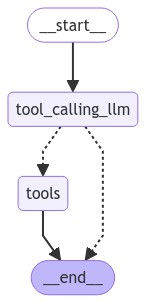

In [8]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# State
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages = graph.invoke({"messages": ("user", "Multiply 3 and 2")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 3 and 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_WqZ8IKUKoFJrci4cGmRng9vj)
 Call ID: call_WqZ8IKUKoFJrci4cGmRng9vj
  Args:
    a: 3
    b: 2
================================= Tool Message =================================
Name: multiply

6


Now, we can see that the graph runs the tool!

It responds with a `ToolMessage`. 

## LangGraph Studio

Load the `router` in the UI, which uses `assistant/router.py` set in `assistant/langgraph.json`.

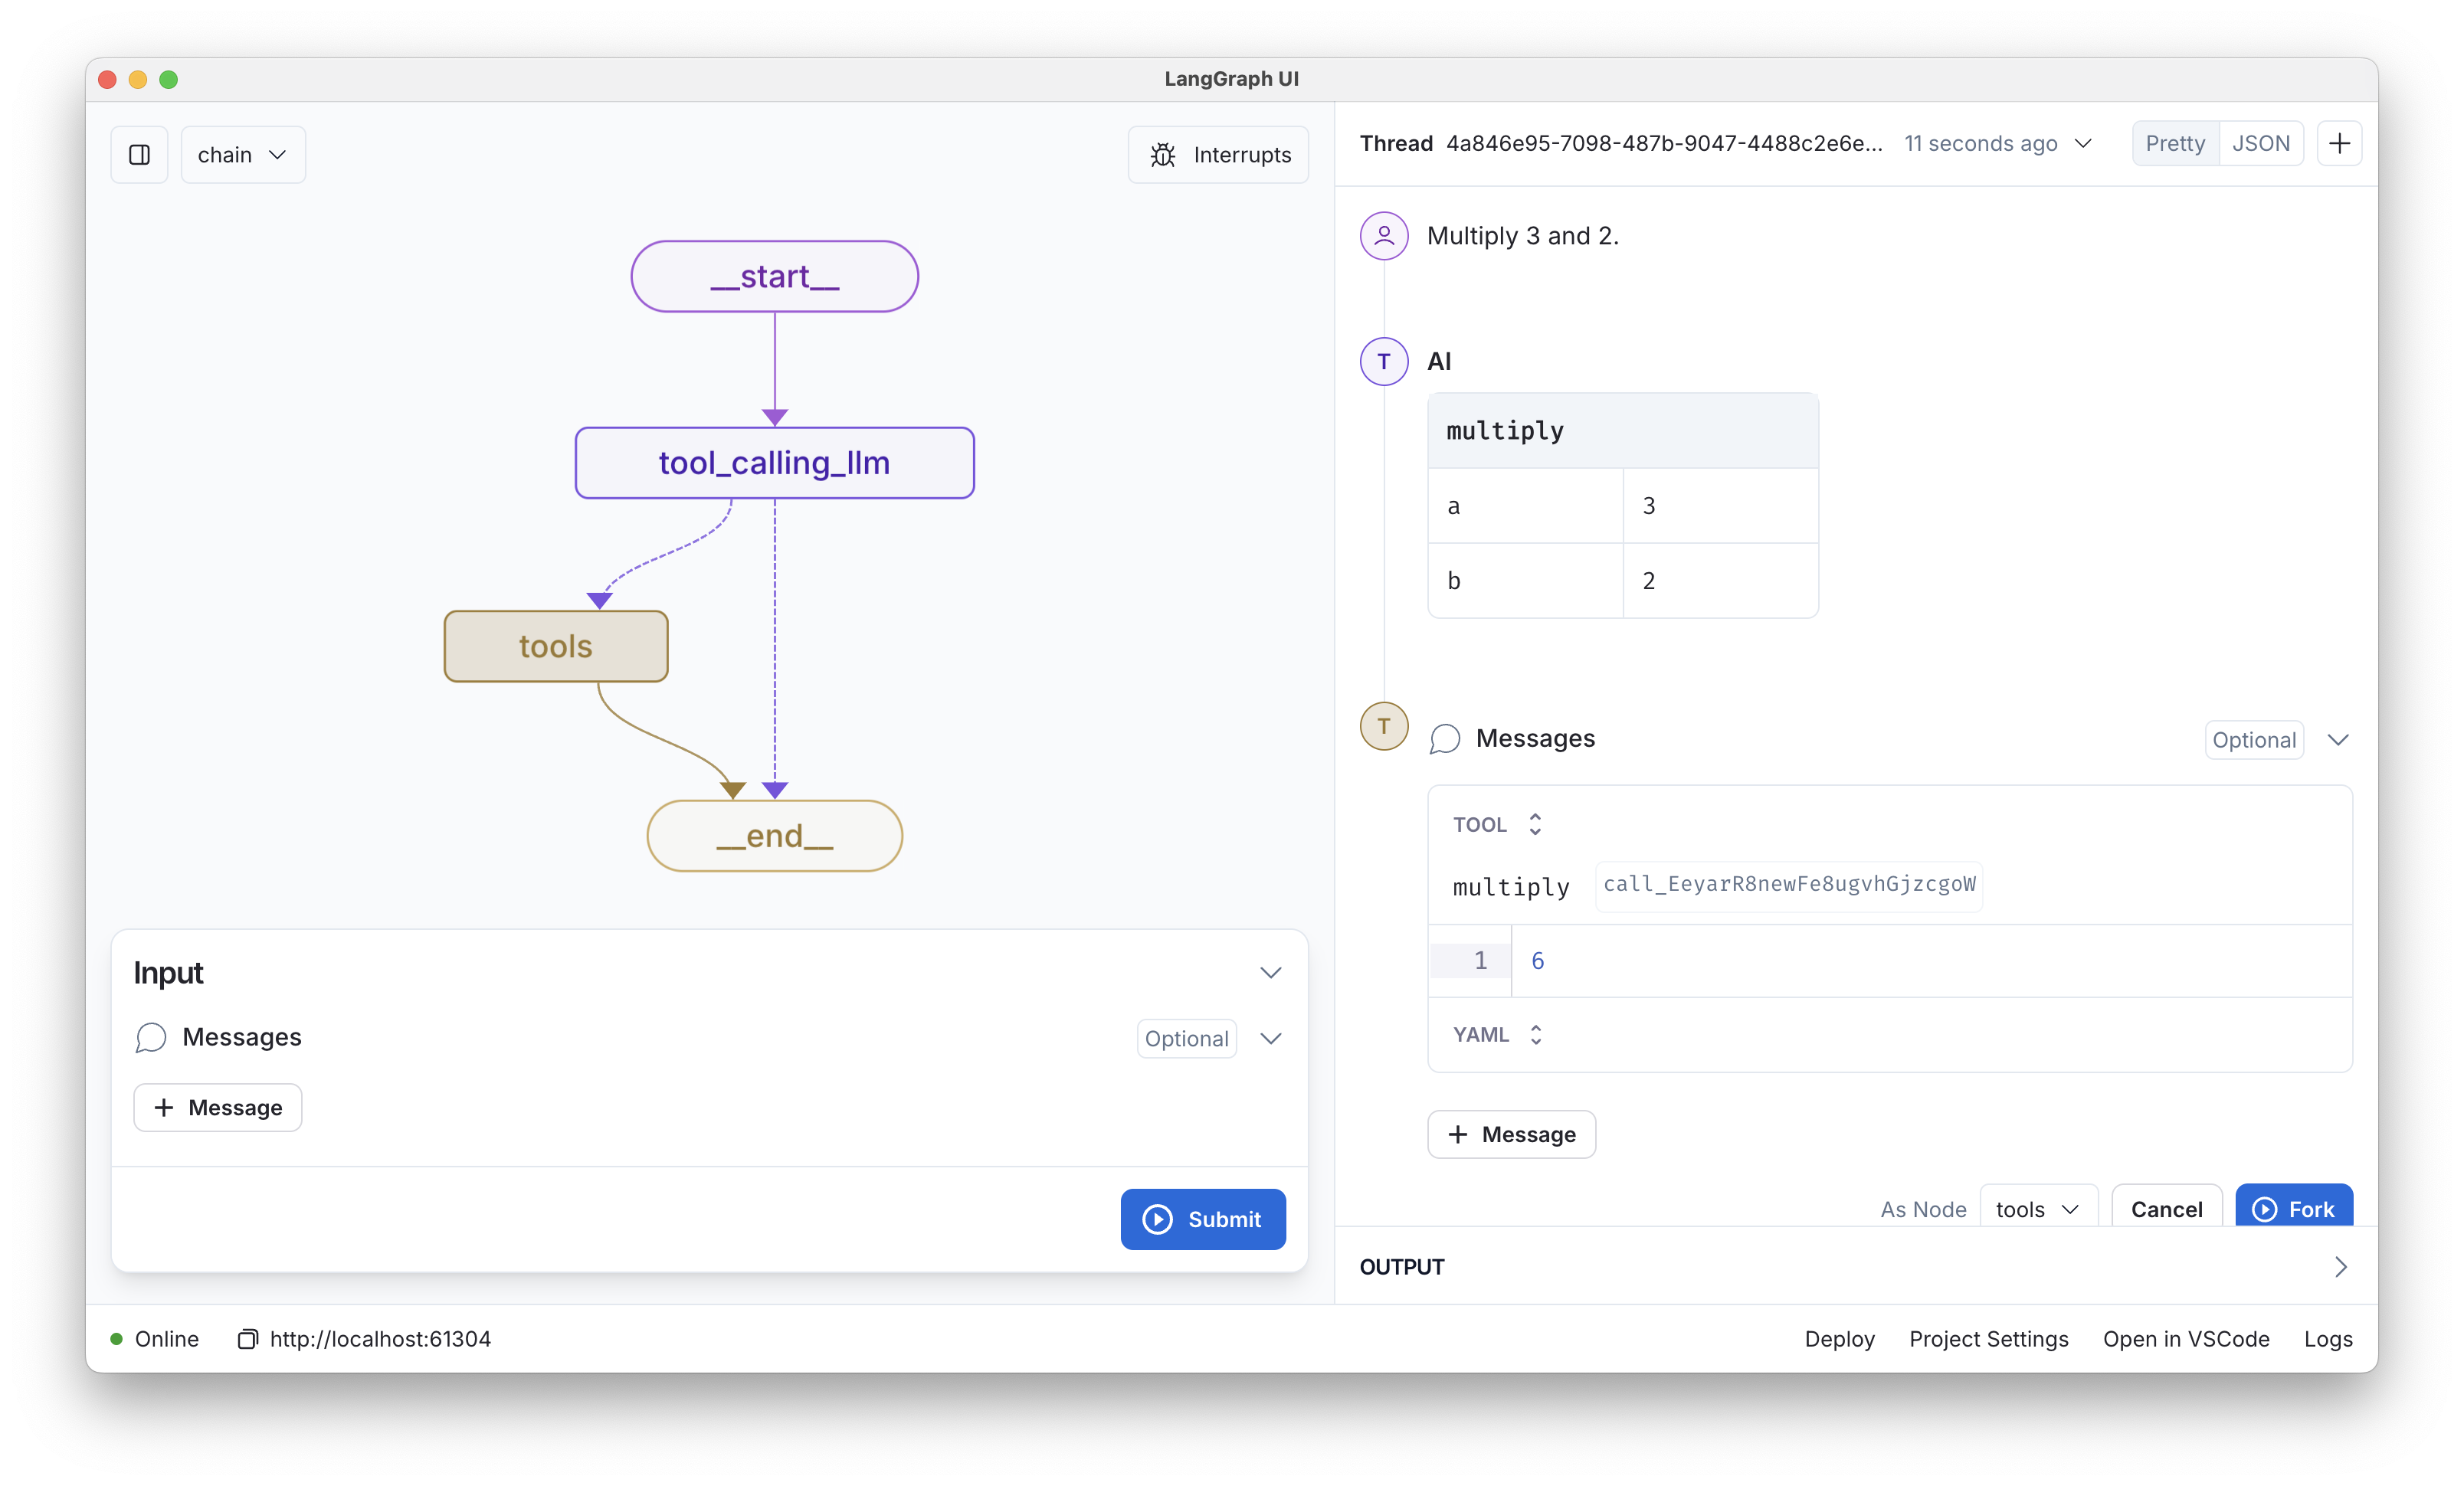